In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [4]:
###############
# Import Data #
###############

DATA = "data.csv"
raw_data = pd.read_csv("DATA, sep=";")

#print("raw_data: info")
#print(raw_data.info())
#print("")
#print("raw_data: describe")
#print(raw_data.describe())
#print("Share of nan:")
#print(raw_data.isna().sum() / raw_data.shape[0])

ID = raw_data["id"]

In [6]:
###################
# Remove  columns #
###################

# Remove high-nan columns
THRESHOLD = 1 #percent data not-nan
short_data = raw_data.dropna(axis=1, thresh=int(THRESHOLD*len(raw_data)))

#print("Share of nan:")
#print(short_data.isna().sum() / short_data.shape[0])
#print(short_data.salesarea_code.unique())

# Remove additional columns
remove = ["id", "role", "blocked", "createdUTC", "updatedUTC", "updated_local", "created_local", "clientid", "country_iso2", "salesarea_code",
         "salesregion_code"]
short_data = short_data.drop(columns=remove)

In [8]:
##################
# Scale numerics #
##################
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

#TO-DO: K-Means funktioniert nur auf numerical values! Idee: andere Cluster-Methode? DBSCAN evtl.?
categories = ["country_of_residence", "status", "marketing_allowance", "pref_lang", "u_act_user_cur_year", "u_act_user_last_12m"]

numerics = ["uh_amount_inc_reservations", "uh_amount_cancellations", "uh_amount_no_shows", "uh_amount_bookings",
           "uh_sum_booking_length", "uh_total_net_revenue", "uh_amount_fulfilled_coupon_redemptions", "uh_total_discount_value_net"]

ct = ColumnTransformer([
        ("unwichtig", StandardScaler(), numerics)
    ])
scaled_numeric_data = pd.DataFrame(ct.fit_transform(short_data))

In [9]:
#####################################
# K-Modes (eigentlich K-Prototypes) #
#####################################
from kmodes.kprototypes import KPrototypes

TOPROWS = 100000

ids = raw_data["id"].head(TOPROWS)

kproto_data = pd.concat([scaled_numeric_data,short_data[categories]], axis=1)
kproto_data = kproto_data.head(TOPROWS)
kproto_data = kproto_data.as_matrix()

kproto = KPrototypes(n_clusters=4, init="Cao", verbose=1)
clusters = kproto.fit_predict(kproto_data, categorical=[8, 9, 10, 11, 12, 13])

print("")
print("Clustering beendet")
print("")

# Print cluster centroids of the trained model.
#print(kproto.cluster_centroids_)
# Print training statistics
print("Training Statistics:")
print("kproto.cost_: ", kproto.cost_)
print("kproto.n_iter_: ", kproto.n_iter_)
print("")

#for s, c in zip(ids, clusters):
#    print("ID: {}, cluster:{}".format(s, c))

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 687, ncost: 35909.79687830545
Run: 1, iteration: 2/100, moves: 216, ncost: 34755.95542855077
Run: 1, iteration: 3/100, moves: 154, ncost: 33859.24936824645
Run: 1, iteration: 4/100, moves: 93, ncost: 33139.93411263904
Run: 1, iteration: 5/100, moves: 83, ncost: 31655.949415099214
Run: 1, iteration: 6/100, moves: 62, ncost: 30211.674458533063
Run: 1, iteration: 7/100, moves: 53, ncost: 28771.067450143495
Run: 1, iteration: 8/100, moves: 23, ncost: 28666.836216552118
Run: 1, iteration: 9/100, moves: 0, ncost: 28666.836216552118

Clustering beendet

Training Statistics:
kproto.cost_:  28666.836216552118
kproto.n_iter_:  9



K = :  1
Cost:
63695.50000001288

K = :  2
Cost:
43806.48894654346

K = :  3
Cost:
34908.66918372729

K = :  4
Cost:
28623.201575575888

K = :  5
Cost:
23820.560449592263

K = :  6
Cost:
25653.978039345497

K = :  7
Cost:
19625.036411834284

K = :  8
Cost:
16689.81023750117

K = :  9
Cost:
17852.376807418517



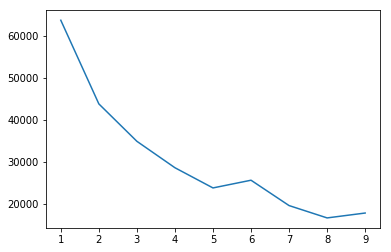

In [10]:
##########################################################
# K-Modes (eigentlich K-Prototypes): All Costs - what K? #
##########################################################

costs = pd.DataFrame(columns=["K", "Costs"])
number_clusters = range(1, 10)

for i in number_clusters:
    kproto = KPrototypes(n_clusters=i, init="Cao", verbose=0)
    clusters = kproto.fit_predict(kproto_data, categorical=[8, 9, 10, 11, 12, 13])
    print("K = : ", i)
    print("Cost:")
    print(kproto.cost_)
    print("")
    costs.loc[i] = [i,kproto.cost_]


plt.plot(costs["Costs"])
plt.show()

results shape:  (7612, 3)


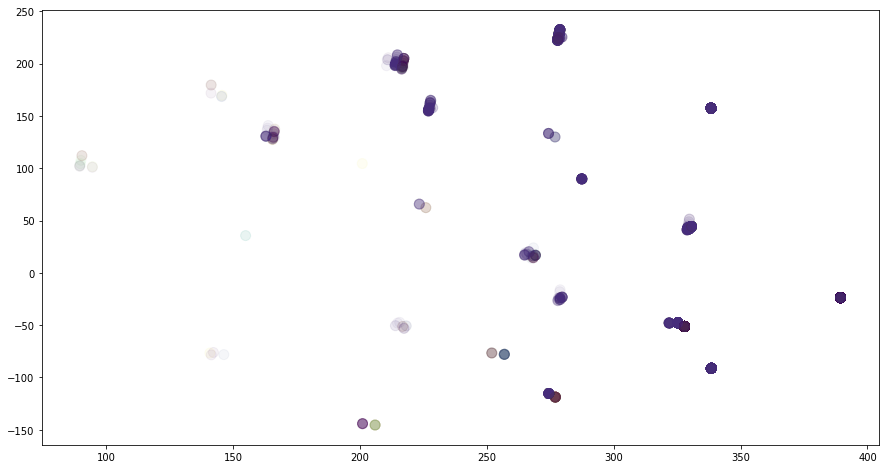

In [11]:
########################################
# FAMD (Factor Analysis of Mixed Data) #
########################################

import prince

famd_data = pd.concat([scaled_numeric_data,short_data[categories]], axis=1)
famd_data["marketing_allowance"] = famd_data["marketing_allowance"].astype(object)


famd = prince.FAMD(
     n_components=2,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42)

famd = famd.fit(famd_data)
results = famd.row_coordinates(famd_data)
results = pd.concat([pd.Series(clusters), results], axis=1)
results.columns = ["Cluster", "Reduced_Factor_1", "Reduced_Factor_2"]

print("results shape: ", results.shape)

plt.figure(figsize=(15,8))
plt.scatter(results["Reduced_Factor_1"], results["Reduced_Factor_2"], s=100, c=results["Cluster"], alpha=0.05)
plt.show()

In [12]:
####################################
# FAMD & K-Prototypes: Export Data #
####################################

reduced_clustered_ = pd.concat([results,raw_data], axis=1)
reduced_clustered_.to_csv("reduced_clustered_.csv", index=False)

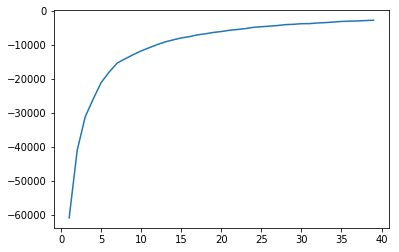

In [13]:
###############################
# K-Means Clustering: what K? #
###############################

number_clusters = range(1, 40)
kmeans = [KMeans(n_clusters=i) for i in number_clusters]

score = [kmeans[i].fit(scaled_numeric_data).score(scaled_numeric_data) for i in range(len(kmeans))]

plt.plot(number_clusters, score)
plt.show()

In [14]:
##############################
# K-Means clustering for K=7 #
##############################

kmeans = KMeans(n_clusters=7)
kmeans.fit(scaled_numeric_data)
kmeans_labels = pd.Series(kmeans.labels_)

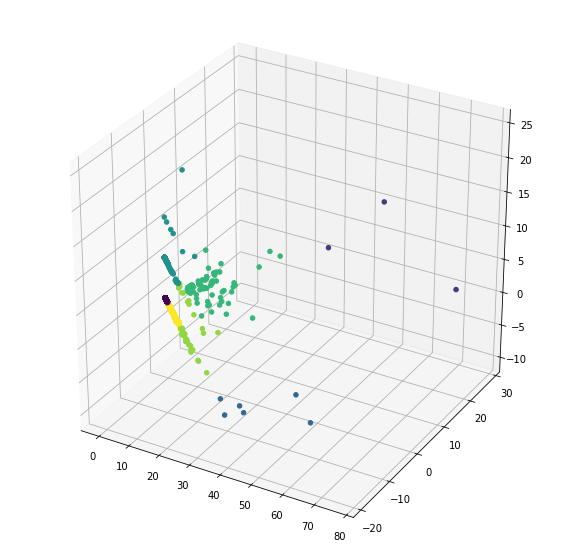

In [15]:
################################
# Visualization kmeans via PCA #
################################
number_PCA = 3

pca = PCA(n_components=number_PCA)
pca.fit(scaled_numeric_data)
pca_data = pca.transform(scaled_numeric_data)
pca_data = pd.DataFrame(pca_data)

# merge relevant data
viz_data = pd.concat([ID, pca_data, kmeans_labels], axis=1, join_axes=[ID.index])
viz_data.columns = ["id", "pca_1", "pca_2", "pca_3", "kmeans_labels"]

# visualize resulting data
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111, projection='3d')
#ax = fig.add_subplot(111)
#ax.scatter(viz_data["pca_1"], viz_data["pca_2"], c=viz_data["kmeans_labels"], alpha=1)
ax.scatter(viz_data["pca_1"], viz_data["pca_2"], viz_data["pca_3"], c=viz_data["kmeans_labels"], alpha=1)
plt.show()

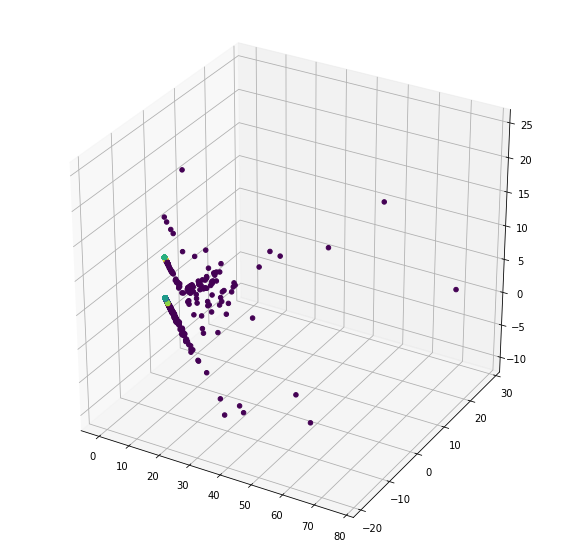

In [16]:
#####################
# DBSCAN Clustering #
#####################

db = DBSCAN(eps=0.3, min_samples=10).fit(scaled_numeric_data)
dbscan_labels = pd.Series(db.labels_)

viz_data2 = pd.concat([ID, pca_data, dbscan_labels], axis=1, join_axes=[ID.index])
viz_data2.columns = ["id", "pca_1", "pca_2", "pca_3", "dbscan_labels"]

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(viz_data2["pca_1"], viz_data2["pca_2"], viz_data2["pca_3"], c=viz_data2["dbscan_labels"], alpha=1)
plt.show()

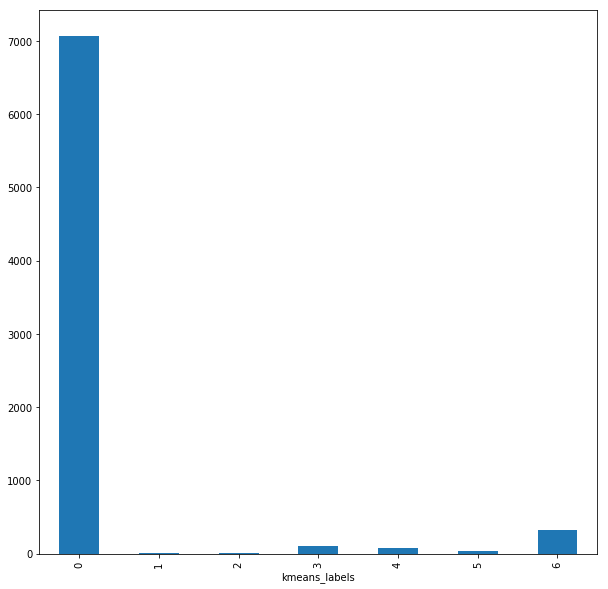

In [17]:
##################################
# Interpreting Kmeans Clustering #
##################################

raw_data["kmeans_labels"] = kmeans_labels


plt.subplots(figsize=(10,10))
raw_data.groupby(["kmeans_labels"]).count()["id"].plot.bar()

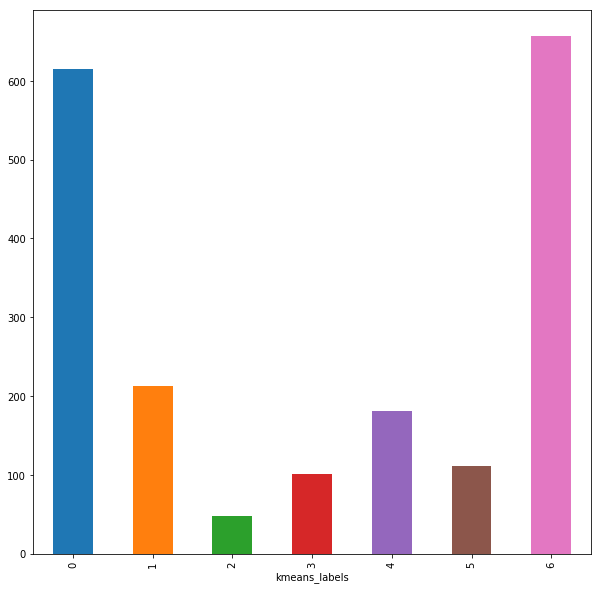

In [11]:
plt.subplots(figsize=(10,10))
raw_data.groupby(["kmeans_labels"]).sum()["uh_amount_bookings"].plot.bar()

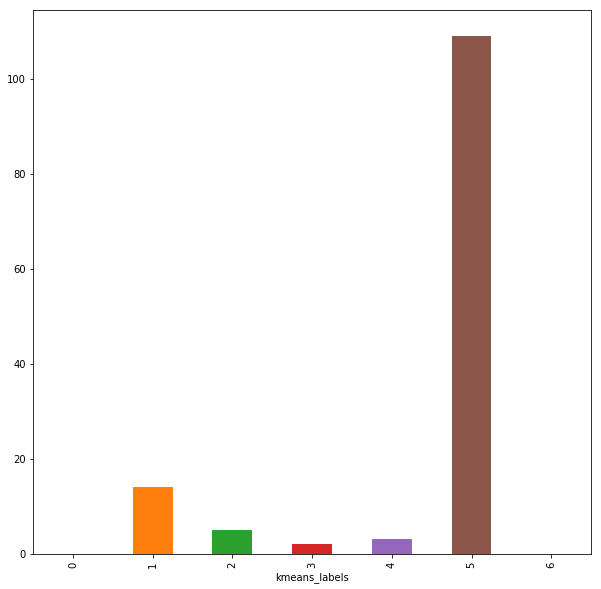

In [12]:
plt.subplots(figsize=(10,10))
raw_data.groupby(["kmeans_labels"]).sum()["uh_amount_no_shows"].plot.bar()

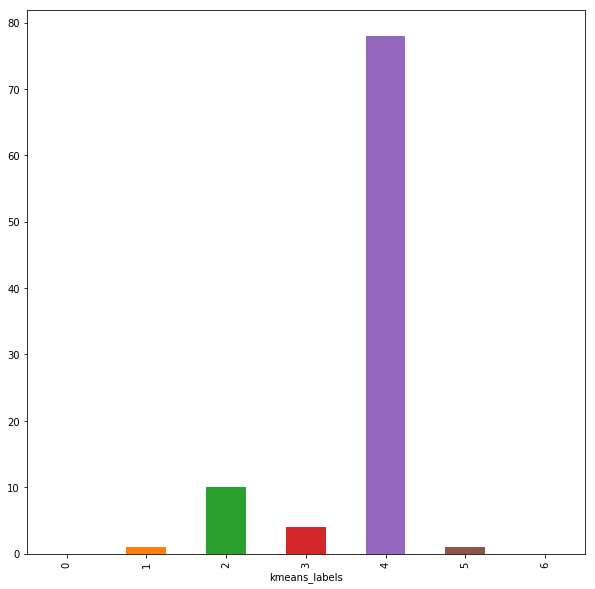

In [13]:
plt.subplots(figsize=(10,10))
raw_data.groupby(["kmeans_labels"]).sum()["uh_amount_fulfilled_coupon_redemptions"].plot.bar()

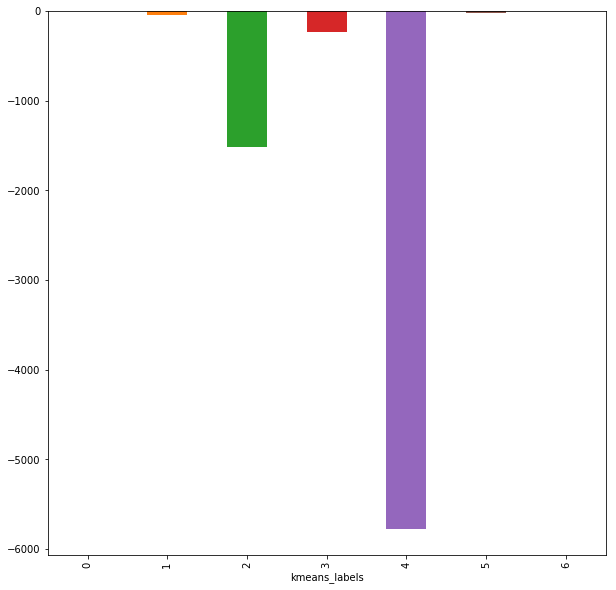

In [14]:
plt.subplots(figsize=(10,10))
raw_data.groupby(["kmeans_labels"]).sum()["uh_total_discount_value_net"].plot.bar()